In [1]:
import os
import numpy as np
import pandas as pd
import torch
import os
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle
import glob
import os.path as osp
DATA_DIR = '/mnt/chicm/data/open-images/relation'
DETECT_DATA_DIR = '/mnt/chicm/data/open-images/detect'
IMG_DIR = '/mnt/chicm/data/open-images/train/imgs'
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'

In [2]:
img_files = glob.glob(IMG_DIR + '/**/*.jpg')
fullpath_dict = {}
for fn in img_files:
    fullpath_dict[osp.basename(fn).split('.')[0]] = fn

In [3]:
fullpath_dict['780d8a470d144fa0']

'/mnt/chicm/data/open-images/train/imgs/train_7/780d8a470d144fa0.jpg'

In [158]:
!ls $DATA_DIR

challenge-2019-attributes-description.csv
challenge-2019-classes-vrd.csv
challenge-2019-relationships-description.csv
challenge-2019-relationship-triplets.csv
challenge-2019-train-vrd-bbox.csv
challenge-2019-train-vrd.csv
challenge-2019-train-vrd-labels.csv
challenge-2019-validation-vrd-bbox.csv
challenge-2019-validation-vrd.csv
challenge-2019-validation-vrd-labels.csv
classes_is_42.csv
negative_tuples.csv
top_classes.csv
VRD_sample_submission.csv


In [122]:
df_classes = pd.read_csv(osp.join(DATA_DIR, 'challenge-2019-classes-vrd.csv'), names=['classes', 'desc'])
#df_classes.head()
def get_class_name(label):
    return df_classes.loc[df_classes.classes==label].desc.values[0]

In [123]:
df_box = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-train-vrd-bbox.csv'))
                     #dtype={'XMin':str, 'XMax':str, 'YMin': str, 'YMax': str})
df_box.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax,IsGroupOf
0,780d8a470d144fa0,/m/04yx4,0.000000,0.527143,0.029979,0.997859,0
1,780d8a470d144fa0,/m/04yx4,0.291429,0.687143,0.128480,0.997859,0
2,780d8a470d144fa0,/m/04yx4,0.590000,0.965714,0.164882,0.997859,0
3,780db0a7d07a4a20,/m/026t6,0.000000,1.000000,0.345625,0.990000,-1
4,780db0a7d07a4a20,/m/026t6,0.271667,0.626667,0.803125,0.999375,0


In [124]:
df_box.shape

(3290070, 7)

In [126]:
df_vrd = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-train-vrd.csv'))
    #converters={
    #'XMin1':lambda x: '{:.6f}'.format(float(x)),
    #'XMax1':lambda x: '{:.6f}'.format(float(x)),
    #'YMin1':lambda x: '{:.6f}'.format(float(x)),
    #'YMax1':lambda x: '{:.6f}'.format(float(x))})
df_vrd.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
0,fe58ec1b06db2bb7,/m/04bcr3,/m/083vt,0.00500,0.033125,0.580000,0.627778,0.00500,0.033125,0.580000,0.627778,is
1,82d16a22f703df5c,/m/04dr76w,/m/02gy9n,0.61200,0.735000,0.418919,0.950450,0.61200,0.735000,0.418919,0.950450,is
2,b54d41beabcfd900,/m/01mzpv,/m/083vt,0.37250,0.399375,0.706413,0.778557,0.37250,0.399375,0.706413,0.778557,is
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.17125,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.85500,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at


In [127]:
df_vrd.shape

(374768, 12)

In [128]:
df_pos = df_vrd.loc[df_vrd.RelationshipLabel!='is'].copy()

In [129]:
df_pos.RelationshipLabel.value_counts()

at                111493
on                 31604
holds              20986
plays               8932
interacts_with      3756
inside_of           2392
wears                836
hits                 593
under                 34
Name: RelationshipLabel, dtype: int64

In [130]:
print(df_pos.shape, len(df_pos.ImageID.unique()), len(df_pos.LabelName1.unique()),\
      len(df_pos.LabelName2.unique()), len(df_pos.RelationshipLabel.unique()))

(180626, 12) 57187 17 53 9


In [131]:
classes_1 = df_pos.LabelName1.unique()
print(classes_1, len(classes_1))
print([get_class_name(x) for x in classes_1])

['/m/01mzpv' '/m/04yx4' '/m/03bt1vf' '/m/05r655' '/m/01bl7v' '/m/04dr76w'
 '/m/09tvcd' '/m/02p5f1q' '/m/02jvh9' '/m/0dt3t' '/m/0bt9lr' '/m/0cmx8'
 '/m/01599' '/m/04ctx' '/m/01yrx' '/m/01_5g' '/m/03qrc'] 17
['Chair', 'Man', 'Woman', 'Girl', 'Boy', 'Bottle', 'Wine glass', 'Coffee cup', 'Mug', 'Fork', 'Dog', 'Spoon', 'Beer', 'Knife', 'Cat', 'Chopsticks', 'Hamster']


In [132]:
classes_2 = df_pos.LabelName2.unique()
print(classes_2, len(classes_2))
print([get_class_name(x) for x in classes_2])


['/m/01y9k5' '/m/04bcr3' '/m/0199g' '/m/078n6m' '/m/05_5p_0' '/m/01mzpv'
 '/m/0hg7b' '/m/0k4j' '/m/0dv5r' '/m/0dv9c' '/m/0342h' '/m/09tvcd'
 '/m/01226z' '/m/050k8' '/m/0cvnqh' '/m/0bt9lr' '/m/04_sv' '/m/01599'
 '/m/04dr76w' '/m/07y_7' '/m/03ssj5' '/m/080hkjn' '/m/026t6' '/m/02p5f1q'
 '/m/03m3pdh' '/m/03k3r' '/m/0h8my_4' '/m/0wdt60w' '/m/071p9' '/m/0pg52'
 '/m/01940j' '/m/06__v' '/m/05r5c' '/m/0cmx8' '/m/0l14j_' '/m/04ctx'
 '/m/019w40' '/m/01yrx' '/m/0bwd_0j' '/m/01_5g' '/m/0h2r6' '/m/08pbxl'
 '/m/01s55n' '/m/01f91_' '/m/02jvh9' '/m/0584n8' '/m/078jl' '/m/02hj4'
 '/m/05ctyq' '/m/03qrc' '/m/0dt3t' '/m/029bxz' '/m/0fx9l'] 53
['Desk', 'Table', 'Bicycle', 'Coffee table', 'Table tennis racket', 'Chair', 'Microphone', 'Car', 'Camera', 'Racket', 'Guitar', 'Wine glass', 'Football', 'Mobile phone', 'Bench', 'Dog', 'Motorcycle', 'Beer', 'Bottle', 'Violin', 'Bed', 'Handbag', 'Drum', 'Coffee cup', 'Sofa bed', 'Horse', 'Tennis racket', 'Rugby ball', 'Ski', 'Taxi', 'Backpack', 'Snowboard', 'Piano', '

In [133]:
print(set(classes_1) - set(classes_2))

{'/m/04yx4', '/m/01bl7v', '/m/03bt1vf', '/m/05r655'}


In [134]:
df_trip = pd.read_csv(osp.join(DATA_DIR, 'challenge-2019-relationship-triplets.csv'))
df_trip_tuple = df_trip.loc[df_trip.RelationshipLabel!='is']
df_trip_tuple.shape

(287, 3)

In [135]:
pos_img_ids = set(df_pos.ImageID.values)
#len(pos_img_ids)
list(pos_img_ids)[:2]

['d017169ef8bac037', 'd21a81893004fa54']

In [136]:
tuple_classes = set(classes_1) | set(classes_2)
print(len(tuple_classes), list(tuple_classes)[:2])

57 ['/m/026t6', '/m/01y9k5']


In [137]:
len(df_box.ImageID.unique())

790478

In [138]:
df_box_neg = df_box.loc[~df_box.ImageID.isin(pos_img_ids)]
len(df_box_neg.ImageID.unique())

733291

In [139]:
groups = list(df_box_neg.groupby('ImageID'))

In [140]:
groups[0]

('000002b66c9c498e',
                  ImageID  LabelName      XMin      XMax      YMin      YMax  \
 909088  000002b66c9c498e  /m/04bcr3  0.064062  0.492188  0.889063  0.993750   
 909089  000002b66c9c498e  /m/04bcr3  0.301562  0.990625  0.462500  0.595312   
 909090  000002b66c9c498e  /m/04bcr3  0.312500  0.578125  0.351562  0.464063   
 
         IsGroupOf  
 909088          0  
 909089          0  
 909090          0  )

In [141]:
type(groups[0][1].iloc[0].LabelName)

str

In [142]:
groups[0][1]

,ImageID,LabelName,XMin,XMax,YMin,YMax,IsGroupOf
909088,000002b66c9c498e,/m/04bcr3,0.064062,0.492188,0.889063,0.993750,0
909089,000002b66c9c498e,/m/04bcr3,0.301562,0.990625,0.462500,0.595312,0
909090,000002b66c9c498e,/m/04bcr3,0.312500,0.578125,0.351562,0.464063,0


In [143]:
len(groups)

733291

In [144]:
df_pos.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.171250,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.855000,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at
5,03b5764a5c600aa4,/m/04yx4,/m/0199g,0.114068,0.205323,0.334375,0.453750,0.13308,0.200570,0.383750,0.465625,on
6,d18adac47a838d35,/m/03bt1vf,/m/04bcr3,0.531875,0.597500,0.054409,0.196060,0.00000,0.999375,0.147280,0.447467,at
7,487e3f4413229d30,/m/04yx4,/m/04bcr3,0.281250,0.706875,0.103578,0.780603,0.00000,0.999375,0.731638,0.999058,at


In [145]:
import random
def get_neg_sample(group):
    img_id, group = group
    n = len(group.LabelName.values)
    if n < 2:
        return []
    used = set()
    result = []
    for _ in range(20):
        idx1 = random.choice(list(range(n)))
        idx2 = random.choice(list(range(n)))
        if (idx1 != idx2) and ((idx1, idx2) not in used):
            row1 = group.iloc[idx1]
            row2 = group.iloc[idx2]
            label_name1 = row1.LabelName
            label_name2 = row2.LabelName
            if label_name1 in set(classes_1) and label_name2 in set(classes_2):
                result.append({
                    'ImageID': img_id,
                    'LabelName1': label_name1,
                    'LabelName2': label_name2,
                    'XMin1': row1.XMin,
                    'XMax1': row1.XMax,
                    'YMin1': row1.YMin,
                    'YMax1': row1.YMax,
                    'XMin2': row2.XMin,
                    'XMax2': row2.XMax,
                    'YMin2': row2.YMin,
                    'YMax2': row2.YMax,
                    'RelationshipLabel': 'none'
                })
                #result.append((group.iloc[idx1], group.iloc[idx2]))
                used.add((idx1, idx2))
        if len(used) >= 10:
            break
    #print(len(result))
    return result

In [146]:
from multiprocessing import Pool
with Pool(50) as p:
    samples = list(tqdm(iterable=p.imap_unordered(get_neg_sample, groups), total=len(groups)))




  0%|          | 0/733291 [00:00<?, ?it/s]


  0%|          | 279/733291 [00:00<04:22, 2788.16it/s]


  0%|          | 574/733291 [00:00<04:18, 2834.80it/s]


  0%|          | 981/733291 [00:00<03:55, 3112.14it/s]


  0%|          | 1273/733291 [00:00<04:09, 2939.66it/s]


  0%|          | 1669/733291 [00:00<03:49, 3184.01it/s]


  0%|          | 2146/733291 [00:00<03:27, 3530.95it/s]


  0%|          | 2487/733291 [00:00<03:31, 3448.97it/s]


  0%|          | 2834/733291 [00:00<03:31, 3448.77it/s]


  0%|          | 3173/733291 [00:00<03:32, 3428.68it/s]


  0%|          | 3552/733291 [00:01<03:26, 3529.16it/s]


  1%|          | 3928/733291 [00:01<03:22, 3593.42it/s]


  1%|          | 4326/733291 [00:01<03:18, 3666.83it/s]


  1%|          | 4728/733291 [00:01<03:15, 3733.41it/s]


  1%|          | 5130/733291 [00:01<03:13, 3757.47it/s]


  1%|          | 5506/733291 [00:01<03:17, 3688.76it/s]


  1%|          | 5927/733291 [00:01<03:10, 3825.60it/s]


  1%|          | 6319/73329

 13%|█▎        | 97384/733291 [00:26<02:55, 3628.07it/s]


 13%|█▎        | 97820/733291 [00:26<02:49, 3752.52it/s]


 13%|█▎        | 98237/733291 [00:26<02:44, 3862.49it/s]


 13%|█▎        | 98629/733291 [00:26<03:06, 3399.25it/s]


 13%|█▎        | 98983/733291 [00:26<03:08, 3369.25it/s]


 14%|█▎        | 99374/733291 [00:26<03:14, 3252.03it/s]


 14%|█▎        | 99808/733291 [00:27<03:00, 3505.97it/s]


 14%|█▎        | 100170/733291 [00:27<03:01, 3493.61it/s]


 14%|█▎        | 100528/733291 [00:27<03:01, 3490.98it/s]


 14%|█▍        | 100965/733291 [00:27<02:51, 3680.60it/s]


 14%|█▍        | 101405/733291 [00:27<02:43, 3868.30it/s]


 14%|█▍        | 101838/733291 [00:27<02:38, 3978.19it/s]


 14%|█▍        | 102242/733291 [00:27<02:40, 3934.74it/s]


 14%|█▍        | 102671/733291 [00:27<02:36, 4034.38it/s]


 14%|█▍        | 103079/733291 [00:27<02:36, 4039.35it/s]


 14%|█▍        | 103504/733291 [00:27<02:34, 4064.18it/s]


 14%|█▍        | 103913/733291 [00:28<02:50, 36

 27%|██▋       | 195251/733291 [00:52<02:10, 4116.33it/s]


 27%|██▋       | 195682/733291 [00:52<02:20, 3836.48it/s]


 27%|██▋       | 196083/733291 [00:52<02:26, 3674.83it/s]


 27%|██▋       | 196464/733291 [00:52<02:33, 3486.94it/s]


 27%|██▋       | 196856/733291 [00:52<02:29, 3578.16it/s]


 27%|██▋       | 197262/733291 [00:52<02:24, 3701.89it/s]


 27%|██▋       | 197820/733291 [00:53<02:10, 4110.39it/s]


 27%|██▋       | 198251/733291 [00:53<02:14, 3976.55it/s]


 27%|██▋       | 198663/733291 [00:53<02:15, 3954.78it/s]


 27%|██▋       | 199069/733291 [00:53<02:14, 3966.03it/s]


 27%|██▋       | 199489/733291 [00:53<02:12, 4023.60it/s]


 27%|██▋       | 199897/733291 [00:53<02:30, 3548.08it/s]


 27%|██▋       | 200266/733291 [00:53<02:33, 3462.37it/s]


 27%|██▋       | 200640/733291 [00:53<02:33, 3464.10it/s]


 27%|██▋       | 200997/733291 [00:53<02:32, 3493.51it/s]


 27%|██▋       | 201377/733291 [00:54<02:30, 3543.88it/s]


 28%|██▊       | 201883/733291 [00:54<02

 40%|████      | 294605/733291 [01:17<01:57, 3744.30it/s]


 40%|████      | 294989/733291 [01:17<01:58, 3686.27it/s]


 40%|████      | 295462/733291 [01:18<01:51, 3941.45it/s]


 40%|████      | 295872/733291 [01:18<01:49, 3984.99it/s]


 40%|████      | 296288/733291 [01:18<01:48, 4035.69it/s]


 40%|████      | 296697/733291 [01:18<01:53, 3861.47it/s]


 41%|████      | 297143/733291 [01:18<01:48, 4019.79it/s]


 41%|████      | 297551/733291 [01:18<02:03, 3526.27it/s]


 41%|████      | 298115/733291 [01:18<01:49, 3972.89it/s]


 41%|████      | 298660/733291 [01:18<01:40, 4312.18it/s]


 41%|████      | 299120/733291 [01:18<01:42, 4227.71it/s]


 41%|████      | 299564/733291 [01:19<01:44, 4167.20it/s]


 41%|████      | 299996/733291 [01:19<01:54, 3796.12it/s]


 41%|████      | 300518/733291 [01:19<01:45, 4120.38it/s]


 41%|████      | 300950/733291 [01:19<01:43, 4178.25it/s]


 41%|████      | 301382/733291 [01:19<01:50, 3915.94it/s]


 41%|████      | 301787/733291 [01:19<01

 55%|█████▍    | 400273/733291 [01:43<01:22, 4043.11it/s]


 55%|█████▍    | 400687/733291 [01:44<01:22, 4051.53it/s]


 55%|█████▍    | 401136/733291 [01:44<01:19, 4165.69it/s]


 55%|█████▍    | 401558/733291 [01:44<01:21, 4053.16it/s]


 55%|█████▍    | 402000/733291 [01:44<01:19, 4154.55it/s]


 55%|█████▍    | 402420/733291 [01:44<01:27, 3765.77it/s]


 55%|█████▍    | 402813/733291 [01:44<01:27, 3758.72it/s]


 55%|█████▌    | 403322/733291 [01:44<01:21, 4073.58it/s]


 55%|█████▌    | 403784/733291 [01:44<01:18, 4222.30it/s]


 55%|█████▌    | 404217/733291 [01:44<01:27, 3772.05it/s]


 55%|█████▌    | 404814/733291 [01:45<01:17, 4216.93it/s]


 55%|█████▌    | 405264/733291 [01:45<01:19, 4115.61it/s]


 55%|█████▌    | 405696/733291 [01:45<01:20, 4058.59it/s]


 55%|█████▌    | 406117/733291 [01:45<01:19, 4099.30it/s]


 55%|█████▌    | 406538/733291 [01:45<01:22, 3954.59it/s]


 56%|█████▌    | 406986/733291 [01:45<01:20, 4071.46it/s]


 56%|█████▌    | 407400/733291 [01:45<01

 69%|██████▊   | 503742/733291 [02:09<00:58, 3908.11it/s]


 69%|██████▉   | 504142/733291 [02:09<00:59, 3860.14it/s]


 69%|██████▉   | 504545/733291 [02:09<00:58, 3899.89it/s]


 69%|██████▉   | 504947/733291 [02:09<00:58, 3925.82it/s]


 69%|██████▉   | 505343/733291 [02:10<00:59, 3862.83it/s]


 69%|██████▉   | 505746/733291 [02:10<00:58, 3910.72it/s]


 69%|██████▉   | 506139/733291 [02:10<00:58, 3859.74it/s]


 69%|██████▉   | 506580/733291 [02:10<00:56, 4009.47it/s]


 69%|██████▉   | 506997/733291 [02:10<00:56, 3997.37it/s]


 69%|██████▉   | 507409/733291 [02:10<00:56, 4019.72it/s]


 69%|██████▉   | 507813/733291 [02:10<00:56, 3992.23it/s]


 69%|██████▉   | 508214/733291 [02:10<00:56, 3970.16it/s]


 69%|██████▉   | 508649/733291 [02:10<00:55, 4075.91it/s]


 69%|██████▉   | 509104/733291 [02:10<00:53, 4191.69it/s]


 69%|██████▉   | 509525/733291 [02:11<00:54, 4136.98it/s]


 70%|██████▉   | 509941/733291 [02:11<00:54, 4106.56it/s]


 70%|██████▉   | 510353/733291 [02:11<00

 83%|████████▎ | 610848/733291 [02:35<00:30, 4024.49it/s]


 83%|████████▎ | 611389/733291 [02:35<00:28, 4341.72it/s]


 83%|████████▎ | 611845/733291 [02:35<00:30, 4019.49it/s]


 84%|████████▎ | 612334/733291 [02:36<00:28, 4179.36it/s]


 84%|████████▎ | 612784/733291 [02:36<00:28, 4270.47it/s]


 84%|████████▎ | 613223/733291 [02:36<00:29, 4125.73it/s]


 84%|████████▎ | 613645/733291 [02:36<00:29, 4098.52it/s]


 84%|████████▎ | 614062/733291 [02:36<00:31, 3824.57it/s]


 84%|████████▍ | 614752/733291 [02:36<00:26, 4414.69it/s]


 84%|████████▍ | 615303/733291 [02:36<00:25, 4691.73it/s]


 84%|████████▍ | 615805/733291 [02:36<00:26, 4418.31it/s]


 84%|████████▍ | 616273/733291 [02:36<00:28, 4118.68it/s]


 84%|████████▍ | 616707/733291 [02:37<00:30, 3865.01it/s]


 84%|████████▍ | 617113/733291 [02:37<00:30, 3786.75it/s]


 84%|████████▍ | 617506/733291 [02:37<00:31, 3687.74it/s]


 84%|████████▍ | 617918/733291 [02:37<00:30, 3807.53it/s]


 84%|████████▍ | 618307/733291 [02:37<00

 98%|█████████▊| 719264/733291 [03:01<00:03, 4401.64it/s]


 98%|█████████▊| 719722/733291 [03:01<00:03, 4366.52it/s]


 98%|█████████▊| 720171/733291 [03:01<00:03, 4073.20it/s]


 98%|█████████▊| 720591/733291 [03:02<00:03, 4084.61it/s]


 98%|█████████▊| 721102/733291 [03:02<00:02, 4344.83it/s]


 98%|█████████▊| 721578/733291 [03:02<00:02, 4459.05it/s]


 98%|█████████▊| 722033/733291 [03:02<00:02, 4449.29it/s]


 99%|█████████▊| 722484/733291 [03:02<00:02, 4402.79it/s]


 99%|█████████▊| 722929/733291 [03:02<00:02, 4275.56it/s]


 99%|█████████▊| 723364/733291 [03:02<00:02, 4294.74it/s]


 99%|█████████▊| 723797/733291 [03:02<00:02, 4186.16it/s]


 99%|█████████▉| 724219/733291 [03:02<00:02, 4163.58it/s]


 99%|█████████▉| 724638/733291 [03:03<00:02, 3956.96it/s]


 99%|█████████▉| 725097/733291 [03:03<00:01, 4125.10it/s]


 99%|█████████▉| 725517/733291 [03:03<00:01, 4136.08it/s]


 99%|█████████▉| 725934/733291 [03:03<00:01, 4074.55it/s]


 99%|█████████▉| 726344/733291 [03:03<00

In [147]:
neg_samples = []
for results in samples:
    for r in results:
        neg_samples.append(r)

In [148]:
len(neg_samples)

189357

In [149]:
df_neg = pd.DataFrame(neg_samples)
df_neg.head()

,ImageID,LabelName1,LabelName2,RelationshipLabel,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2
0,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.33750,0.67750,0.07125,0.998288,0.991438,0.164384,0.148973
1,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.63625,0.67750,0.36750,0.998288,0.988014,0.164384,0.155822
2,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.93750,0.36750,0.67750,0.988014,0.998288,0.155822,0.164384
3,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.33750,0.36750,0.07125,0.988014,0.991438,0.155822,0.148973
4,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.33750,0.93750,0.07125,0.67750,0.991438,0.998288,0.148973,0.164384


In [157]:
df_neg.to_csv(osp.join(DATA_DIR, 'negative_tuples.csv'), index=False)

In [227]:
def get_iou(row):
    #assert row['XMin1'] <= row['XMax1']
    #assert row['YMin1'] <= row['YMax1']
    #assert row['XMin2'] <= row['XMax2']
    #assert row['YMin2'] <= row['YMax2']

    # determine the coordinates of the intersection rectangle
    x_left = max(row['XMin1'], row['XMin2'])
    y_top = max(row['YMin1'], row['YMin2'])
    x_right = min(row['XMax1'], row['XMax2'])
    y_bottom = min(row['YMax1'], row['YMax2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (row['XMax1'] - row['XMin1']) * (row['YMax1'] - row['YMin1'])
    bb2_area = (row['XMax2'] - row['XMin2']) * (row['YMax2'] - row['YMin2'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [156]:
get_iou(df_neg.iloc[4])

0.0

##  Generate training data

In [161]:
df_train = pd.concat([df_pos, df_neg], axis=0, sort=False)
df_train.shape

(369983, 12)

In [162]:
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.171250,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.855000,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at
5,03b5764a5c600aa4,/m/04yx4,/m/0199g,0.114068,0.205323,0.334375,0.453750,0.13308,0.200570,0.383750,0.465625,on
6,d18adac47a838d35,/m/03bt1vf,/m/04bcr3,0.531875,0.597500,0.054409,0.196060,0.00000,0.999375,0.147280,0.447467,at
7,487e3f4413229d30,/m/04yx4,/m/04bcr3,0.281250,0.706875,0.103578,0.780603,0.00000,0.999375,0.731638,0.999058,at


In [164]:
from sklearn.utils import shuffle
df_train = shuffle(df_train)
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
219965,a95e62f631372cf4,/m/03bt1vf,/m/01mzpv,0.785625,0.883125,0.526266,0.724203,0.830000,0.891250,0.608818,0.879925,on
103453,86589abe1b268010,/m/04dr76w,/m/04bcr3,0.723750,0.791250,0.538305,0.715932,0.000000,0.998125,0.799322,0.999322,none
237303,973280d52939db24,/m/04yx4,/m/0hg7b,0.000000,0.962500,0.105833,0.999167,0.602500,0.934375,0.372500,0.480000,holds
49122,3ae44c16f6b8c54d,/m/02p5f1q,/m/02jvh9,0.120915,0.998366,0.016340,0.986928,0.120915,0.998366,0.017974,0.985294,none
99138,51bc6dbea38c9f89,/m/03bt1vf,/m/04bcr3,0.601875,0.683750,0.495767,0.620884,0.400625,0.716250,0.620884,0.876764,at


In [165]:
df_train['iou'] = df_train.apply(lambda row: get_iou(row), axis=1)
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,iou
219965,a95e62f631372cf4,/m/03bt1vf,/m/01mzpv,0.785625,0.883125,0.526266,0.724203,0.830000,0.891250,0.608818,0.879925,on,0.205876
103453,86589abe1b268010,/m/04dr76w,/m/04bcr3,0.723750,0.791250,0.538305,0.715932,0.000000,0.998125,0.799322,0.999322,none,0.000000
237303,973280d52939db24,/m/04yx4,/m/0hg7b,0.000000,0.962500,0.105833,0.999167,0.602500,0.934375,0.372500,0.480000,holds,0.041492
49122,3ae44c16f6b8c54d,/m/02p5f1q,/m/02jvh9,0.120915,0.998366,0.016340,0.986928,0.120915,0.998366,0.017974,0.985294,none,0.996633
99138,51bc6dbea38c9f89,/m/03bt1vf,/m/04bcr3,0.601875,0.683750,0.495767,0.620884,0.400625,0.716250,0.620884,0.876764,at,0.000000


In [172]:
df_train.drop(['ImageID', 'RelationshipLabel'], axis=1).head()

,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou
219965,/m/03bt1vf,/m/01mzpv,0.785625,0.883125,0.526266,0.724203,0.830000,0.891250,0.608818,0.879925,0.205876
103453,/m/04dr76w,/m/04bcr3,0.723750,0.791250,0.538305,0.715932,0.000000,0.998125,0.799322,0.999322,0.000000
237303,/m/04yx4,/m/0hg7b,0.000000,0.962500,0.105833,0.999167,0.602500,0.934375,0.372500,0.480000,0.041492
49122,/m/02p5f1q,/m/02jvh9,0.120915,0.998366,0.016340,0.986928,0.120915,0.998366,0.017974,0.985294,0.996633
99138,/m/03bt1vf,/m/04bcr3,0.601875,0.683750,0.495767,0.620884,0.400625,0.716250,0.620884,0.876764,0.000000


In [173]:
from sklearn.model_selection import train_test_split

In [177]:
y = df_train.RelationshipLabel
X = df_train.drop(['ImageID', 'RelationshipLabel'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [178]:
y_train[:2]

121995      at
13809     none
Name: RelationshipLabel, dtype: object

In [181]:
X.dtypes

LabelName1     object
LabelName2     object
XMin1         float64
XMax1         float64
YMin1         float64
YMax1         float64
XMin2         float64
XMax2         float64
YMin2         float64
YMax2         float64
iou           float64
dtype: object

In [179]:
categorical_feature_indices = np.where(X.dtypes != np.float)[0]

In [180]:
categorical_feature_indices

array([0, 1])

## Train the model

In [184]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score


In [192]:
model = CatBoostClassifier(
    custom_loss = ['Accuracy'],
    #iterations=100,
    verbose=True
)

In [193]:
len(X_train)

332984

In [194]:
model.fit(
    X_train,
    y_train,
    cat_features=categorical_feature_indices,
    eval_set=(X_val, y_val),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0898125	test: 2.0899994	best: 2.0899994 (0)	total: 660ms	remaining: 10m 59s
1:	learn: 1.9213382	test: 1.9213105	best: 1.9213105 (1)	total: 1.19s	remaining: 9m 55s
2:	learn: 1.7871155	test: 1.7870363	best: 1.7870363 (2)	total: 1.71s	remaining: 9m 29s
3:	learn: 1.6754744	test: 1.6751370	best: 1.6751370 (3)	total: 2.22s	remaining: 9m 11s
4:	learn: 1.5773329	test: 1.5769972	best: 1.5769972 (4)	total: 2.71s	remaining: 8m 59s
5:	learn: 1.4930182	test: 1.4926347	best: 1.4926347 (5)	total: 3.25s	remaining: 8m 58s
6:	learn: 1.4172222	test: 1.4168252	best: 1.4168252 (6)	total: 3.72s	remaining: 8m 47s
7:	learn: 1.3513354	test: 1.3508591	best: 1.3508591 (7)	total: 4.22s	remaining: 8m 43s
8:	learn: 1.2898229	test: 1.2893834	best: 1.2893834 (8)	total: 4.74s	remaining: 8m 41s
9:	learn: 1.2342624	test: 1.2337789	best: 1.2337789 (9)	total: 5.23s	remaining: 8m 37s
10:	learn: 1.1832153	test: 1.1827523	best: 1.1827523 (10)	total: 5.72s	remaining: 8m 34s
11:	learn: 1.1364973	test: 1.1360360	bes

93:	learn: 0.2808282	test: 0.2798278	best: 0.2798278 (93)	total: 48s	remaining: 7m 42s
94:	learn: 0.2789254	test: 0.2779299	best: 0.2779299 (94)	total: 48.5s	remaining: 7m 41s
95:	learn: 0.2771576	test: 0.2761750	best: 0.2761750 (95)	total: 49.1s	remaining: 7m 42s
96:	learn: 0.2753101	test: 0.2743613	best: 0.2743613 (96)	total: 49.5s	remaining: 7m 41s
97:	learn: 0.2736859	test: 0.2727517	best: 0.2727517 (97)	total: 50s	remaining: 7m 40s
98:	learn: 0.2717627	test: 0.2708360	best: 0.2708360 (98)	total: 50.5s	remaining: 7m 39s
99:	learn: 0.2701065	test: 0.2691958	best: 0.2691958 (99)	total: 51s	remaining: 7m 38s
100:	learn: 0.2685008	test: 0.2675946	best: 0.2675946 (100)	total: 51.4s	remaining: 7m 37s
101:	learn: 0.2668796	test: 0.2659879	best: 0.2659879 (101)	total: 51.9s	remaining: 7m 36s
102:	learn: 0.2653328	test: 0.2644476	best: 0.2644476 (102)	total: 52.3s	remaining: 7m 35s
103:	learn: 0.2638492	test: 0.2629931	best: 0.2629931 (103)	total: 52.9s	remaining: 7m 35s
104:	learn: 0.26249

184:	learn: 0.1976751	test: 0.1969350	best: 0.1969350 (184)	total: 1m 35s	remaining: 7m 1s
185:	learn: 0.1973459	test: 0.1966137	best: 0.1966137 (185)	total: 1m 36s	remaining: 7m 1s
186:	learn: 0.1970678	test: 0.1963385	best: 0.1963385 (186)	total: 1m 36s	remaining: 7m
187:	learn: 0.1966612	test: 0.1959288	best: 0.1959288 (187)	total: 1m 37s	remaining: 7m
188:	learn: 0.1963402	test: 0.1955944	best: 0.1955944 (188)	total: 1m 37s	remaining: 6m 59s
189:	learn: 0.1960853	test: 0.1953454	best: 0.1953454 (189)	total: 1m 38s	remaining: 6m 58s
190:	learn: 0.1957092	test: 0.1949633	best: 0.1949633 (190)	total: 1m 38s	remaining: 6m 58s
191:	learn: 0.1953906	test: 0.1946476	best: 0.1946476 (191)	total: 1m 39s	remaining: 6m 57s
192:	learn: 0.1950412	test: 0.1943025	best: 0.1943025 (192)	total: 1m 39s	remaining: 6m 57s
193:	learn: 0.1946632	test: 0.1939203	best: 0.1939203 (193)	total: 1m 40s	remaining: 6m 57s
194:	learn: 0.1942956	test: 0.1935436	best: 0.1935436 (194)	total: 1m 41s	remaining: 6m 57

274:	learn: 0.1766374	test: 0.1762054	best: 0.1762054 (274)	total: 2m 26s	remaining: 6m 26s
275:	learn: 0.1764796	test: 0.1760538	best: 0.1760538 (275)	total: 2m 27s	remaining: 6m 26s
276:	learn: 0.1763440	test: 0.1759453	best: 0.1759453 (276)	total: 2m 27s	remaining: 6m 25s
277:	learn: 0.1761593	test: 0.1757690	best: 0.1757690 (277)	total: 2m 28s	remaining: 6m 25s
278:	learn: 0.1760010	test: 0.1756105	best: 0.1756105 (278)	total: 2m 29s	remaining: 6m 25s
279:	learn: 0.1758934	test: 0.1755027	best: 0.1755027 (279)	total: 2m 29s	remaining: 6m 24s
280:	learn: 0.1757727	test: 0.1753881	best: 0.1753881 (280)	total: 2m 30s	remaining: 6m 24s
281:	learn: 0.1755830	test: 0.1752141	best: 0.1752141 (281)	total: 2m 30s	remaining: 6m 24s
282:	learn: 0.1754485	test: 0.1750839	best: 0.1750839 (282)	total: 2m 31s	remaining: 6m 23s
283:	learn: 0.1752604	test: 0.1749043	best: 0.1749043 (283)	total: 2m 32s	remaining: 6m 23s
284:	learn: 0.1751363	test: 0.1747864	best: 0.1747864 (284)	total: 2m 32s	remain

364:	learn: 0.1658946	test: 0.1658345	best: 0.1658345 (364)	total: 3m 18s	remaining: 5m 45s
365:	learn: 0.1658220	test: 0.1657648	best: 0.1657648 (365)	total: 3m 19s	remaining: 5m 44s
366:	learn: 0.1657068	test: 0.1656565	best: 0.1656565 (366)	total: 3m 19s	remaining: 5m 44s
367:	learn: 0.1655880	test: 0.1655350	best: 0.1655350 (367)	total: 3m 20s	remaining: 5m 43s
368:	learn: 0.1654844	test: 0.1654503	best: 0.1654503 (368)	total: 3m 20s	remaining: 5m 43s
369:	learn: 0.1654576	test: 0.1654325	best: 0.1654325 (369)	total: 3m 21s	remaining: 5m 42s
370:	learn: 0.1654137	test: 0.1653856	best: 0.1653856 (370)	total: 3m 21s	remaining: 5m 42s
371:	learn: 0.1653569	test: 0.1653315	best: 0.1653315 (371)	total: 3m 22s	remaining: 5m 41s
372:	learn: 0.1653066	test: 0.1652832	best: 0.1652832 (372)	total: 3m 23s	remaining: 5m 41s
373:	learn: 0.1652064	test: 0.1651833	best: 0.1651833 (373)	total: 3m 23s	remaining: 5m 40s
374:	learn: 0.1650862	test: 0.1650600	best: 0.1650600 (374)	total: 3m 24s	remain

454:	learn: 0.1594486	test: 0.1597428	best: 0.1597428 (454)	total: 4m 9s	remaining: 4m 59s
455:	learn: 0.1593732	test: 0.1596718	best: 0.1596718 (455)	total: 4m 10s	remaining: 4m 58s
456:	learn: 0.1593119	test: 0.1596180	best: 0.1596180 (456)	total: 4m 11s	remaining: 4m 58s
457:	learn: 0.1592499	test: 0.1595559	best: 0.1595559 (457)	total: 4m 11s	remaining: 4m 57s
458:	learn: 0.1591726	test: 0.1594754	best: 0.1594754 (458)	total: 4m 12s	remaining: 4m 57s
459:	learn: 0.1590557	test: 0.1593593	best: 0.1593593 (459)	total: 4m 12s	remaining: 4m 56s
460:	learn: 0.1590001	test: 0.1593123	best: 0.1593123 (460)	total: 4m 13s	remaining: 4m 56s
461:	learn: 0.1589572	test: 0.1592745	best: 0.1592745 (461)	total: 4m 13s	remaining: 4m 55s
462:	learn: 0.1588597	test: 0.1591887	best: 0.1591887 (462)	total: 4m 14s	remaining: 4m 55s
463:	learn: 0.1587747	test: 0.1591135	best: 0.1591135 (463)	total: 4m 15s	remaining: 4m 54s
464:	learn: 0.1587190	test: 0.1590599	best: 0.1590599 (464)	total: 4m 15s	remaini

544:	learn: 0.1545301	test: 0.1553190	best: 0.1553190 (544)	total: 5m 1s	remaining: 4m 12s
545:	learn: 0.1545019	test: 0.1552946	best: 0.1552946 (545)	total: 5m 2s	remaining: 4m 11s
546:	learn: 0.1544678	test: 0.1552593	best: 0.1552593 (546)	total: 5m 3s	remaining: 4m 11s
547:	learn: 0.1544418	test: 0.1552387	best: 0.1552387 (547)	total: 5m 3s	remaining: 4m 10s
548:	learn: 0.1543663	test: 0.1551618	best: 0.1551618 (548)	total: 5m 4s	remaining: 4m 10s
549:	learn: 0.1543073	test: 0.1551022	best: 0.1551022 (549)	total: 5m 4s	remaining: 4m 9s
550:	learn: 0.1542328	test: 0.1550465	best: 0.1550465 (550)	total: 5m 5s	remaining: 4m 9s
551:	learn: 0.1541788	test: 0.1550114	best: 0.1550114 (551)	total: 5m 6s	remaining: 4m 8s
552:	learn: 0.1541332	test: 0.1549629	best: 0.1549629 (552)	total: 5m 6s	remaining: 4m 7s
553:	learn: 0.1540833	test: 0.1549192	best: 0.1549192 (553)	total: 5m 7s	remaining: 4m 7s
554:	learn: 0.1539963	test: 0.1548280	best: 0.1548280 (554)	total: 5m 7s	remaining: 4m 6s
555:	

634:	learn: 0.1508054	test: 0.1520723	best: 0.1520723 (634)	total: 5m 53s	remaining: 3m 23s
635:	learn: 0.1507709	test: 0.1520450	best: 0.1520450 (635)	total: 5m 54s	remaining: 3m 22s
636:	learn: 0.1507538	test: 0.1520325	best: 0.1520325 (636)	total: 5m 54s	remaining: 3m 22s
637:	learn: 0.1506868	test: 0.1519657	best: 0.1519657 (637)	total: 5m 55s	remaining: 3m 21s
638:	learn: 0.1506455	test: 0.1519309	best: 0.1519309 (638)	total: 5m 56s	remaining: 3m 21s
639:	learn: 0.1506154	test: 0.1519093	best: 0.1519093 (639)	total: 5m 56s	remaining: 3m 20s
640:	learn: 0.1505512	test: 0.1518424	best: 0.1518424 (640)	total: 5m 57s	remaining: 3m 20s
641:	learn: 0.1505282	test: 0.1518263	best: 0.1518263 (641)	total: 5m 57s	remaining: 3m 19s
642:	learn: 0.1504938	test: 0.1517932	best: 0.1517932 (642)	total: 5m 58s	remaining: 3m 18s
643:	learn: 0.1504492	test: 0.1517626	best: 0.1517626 (643)	total: 5m 58s	remaining: 3m 18s
644:	learn: 0.1504125	test: 0.1517267	best: 0.1517267 (644)	total: 5m 59s	remain

724:	learn: 0.1478775	test: 0.1496965	best: 0.1496965 (724)	total: 6m 45s	remaining: 2m 33s
725:	learn: 0.1478369	test: 0.1496644	best: 0.1496644 (725)	total: 6m 45s	remaining: 2m 33s
726:	learn: 0.1478242	test: 0.1496548	best: 0.1496548 (726)	total: 6m 46s	remaining: 2m 32s
727:	learn: 0.1477804	test: 0.1496131	best: 0.1496131 (727)	total: 6m 46s	remaining: 2m 32s
728:	learn: 0.1477517	test: 0.1495923	best: 0.1495923 (728)	total: 6m 47s	remaining: 2m 31s
729:	learn: 0.1477299	test: 0.1495729	best: 0.1495729 (729)	total: 6m 48s	remaining: 2m 30s
730:	learn: 0.1476952	test: 0.1495491	best: 0.1495491 (730)	total: 6m 48s	remaining: 2m 30s
731:	learn: 0.1476811	test: 0.1495404	best: 0.1495404 (731)	total: 6m 49s	remaining: 2m 29s
732:	learn: 0.1476471	test: 0.1495062	best: 0.1495062 (732)	total: 6m 49s	remaining: 2m 29s
733:	learn: 0.1475894	test: 0.1494416	best: 0.1494416 (733)	total: 6m 50s	remaining: 2m 28s
734:	learn: 0.1475705	test: 0.1494181	best: 0.1494181 (734)	total: 6m 50s	remain

814:	learn: 0.1451238	test: 0.1473327	best: 0.1473327 (814)	total: 7m 36s	remaining: 1m 43s
815:	learn: 0.1451142	test: 0.1473301	best: 0.1473301 (815)	total: 7m 37s	remaining: 1m 43s
816:	learn: 0.1450866	test: 0.1473122	best: 0.1473122 (816)	total: 7m 37s	remaining: 1m 42s
817:	learn: 0.1450398	test: 0.1472646	best: 0.1472646 (817)	total: 7m 38s	remaining: 1m 42s
818:	learn: 0.1450199	test: 0.1472537	best: 0.1472537 (818)	total: 7m 39s	remaining: 1m 41s
819:	learn: 0.1449912	test: 0.1472249	best: 0.1472249 (819)	total: 7m 40s	remaining: 1m 41s
820:	learn: 0.1449714	test: 0.1472095	best: 0.1472095 (820)	total: 7m 40s	remaining: 1m 40s
821:	learn: 0.1449635	test: 0.1472022	best: 0.1472022 (821)	total: 7m 41s	remaining: 1m 39s
822:	learn: 0.1449433	test: 0.1471949	best: 0.1471949 (822)	total: 7m 41s	remaining: 1m 39s
823:	learn: 0.1449255	test: 0.1471793	best: 0.1471793 (823)	total: 7m 42s	remaining: 1m 38s
824:	learn: 0.1449043	test: 0.1471661	best: 0.1471661 (824)	total: 7m 43s	remain

904:	learn: 0.1430195	test: 0.1457154	best: 0.1457154 (904)	total: 8m 29s	remaining: 53.5s
905:	learn: 0.1429616	test: 0.1456621	best: 0.1456621 (905)	total: 8m 30s	remaining: 53s
906:	learn: 0.1429462	test: 0.1456524	best: 0.1456524 (906)	total: 8m 31s	remaining: 52.4s
907:	learn: 0.1428944	test: 0.1456048	best: 0.1456048 (907)	total: 8m 31s	remaining: 51.9s
908:	learn: 0.1428568	test: 0.1455694	best: 0.1455694 (908)	total: 8m 32s	remaining: 51.3s
909:	learn: 0.1428490	test: 0.1455696	best: 0.1455694 (908)	total: 8m 33s	remaining: 50.7s
910:	learn: 0.1428306	test: 0.1455604	best: 0.1455604 (910)	total: 8m 33s	remaining: 50.2s
911:	learn: 0.1427972	test: 0.1455382	best: 0.1455382 (911)	total: 8m 34s	remaining: 49.6s
912:	learn: 0.1427649	test: 0.1455127	best: 0.1455127 (912)	total: 8m 34s	remaining: 49.1s
913:	learn: 0.1427476	test: 0.1455047	best: 0.1455047 (913)	total: 8m 35s	remaining: 48.5s
914:	learn: 0.1427296	test: 0.1454887	best: 0.1454887 (914)	total: 8m 35s	remaining: 47.9s
9

995:	learn: 0.1410854	test: 0.1442554	best: 0.1442554 (995)	total: 9m 23s	remaining: 2.26s
996:	learn: 0.1410687	test: 0.1442466	best: 0.1442466 (996)	total: 9m 23s	remaining: 1.7s
997:	learn: 0.1410569	test: 0.1442399	best: 0.1442399 (997)	total: 9m 24s	remaining: 1.13s
998:	learn: 0.1410456	test: 0.1442362	best: 0.1442362 (998)	total: 9m 25s	remaining: 566ms
999:	learn: 0.1410188	test: 0.1442197	best: 0.1442197 (999)	total: 9m 25s	remaining: 0us

bestTest = 0.1442196606
bestIteration = 999



In [196]:
val_preds = model.predict(X_val)

In [199]:
val_preds[:10]

array([['inside_of'],
       ['none'],
       ['at'],
       ['none'],
       ['on'],
       ['none'],
       ['at'],
       ['none'],
       ['none'],
       ['at']], dtype='<U14')

In [200]:
X_val[:10]

,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou
338068,/m/04yx4,/m/0k4j,0.476250,0.748125,0.254902,0.690943,0.000000,0.999375,0.000000,0.999066,0.118734
12585,/m/01mzpv,/m/01mzpv,0.512500,0.781250,0.474672,0.662289,0.517500,0.786250,0.480300,0.705441,0.762757
177078,/m/04yx4,/m/078n6m,0.671250,0.809375,0.345249,0.626529,0.533125,0.861875,0.638758,0.985889,0.000000
28308,/m/01mzpv,/m/01mzpv,0.696875,0.785000,0.719775,0.910028,0.865625,0.999375,0.827554,0.999063,0.000000
305246,/m/04yx4,/m/01mzpv,0.396094,0.481250,0.503125,0.658333,0.469531,0.490625,0.561458,0.643750,0.068939
149105,/m/09tvcd,/m/09tvcd,0.393750,0.468750,0.163333,0.320000,0.341875,0.406250,0.056667,0.218333,0.032022
299264,/m/01mzpv,/m/04bcr3,0.363750,0.679375,0.465000,0.891667,0.035625,0.659375,0.346667,0.792500,0.306444
47051,/m/04yx4,/m/0k4j,0.186458,0.197917,0.279167,0.291667,0.059375,0.354167,0.281944,0.475000,0.001957
18751,/m/01mzpv,/m/01mzpv,0.553750,0.686875,0.716667,0.947500,0.363750,0.455625,0.637500,0.802500,0.000000
28510,/m/05r655,/m/04bcr3,0.535625,0.661250,0.504249,0.753541,0.297500,0.817500,0.674221,0.969783,0.056926


In [210]:
df_train.loc[df_train.index==177078]

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,iou
177078,ed869869647e83ac,/m/04dr76w,/m/04dr76w,0.094531,0.120312,0.329025,0.433608,0.265625,0.296875,0.399530,0.499412,none,0.0
177078,6a0454cfb7b394e7,/m/04yx4,/m/078n6m,0.671250,0.809375,0.345249,0.626529,0.533125,0.861875,0.638758,0.985889,at,0.0


## Peprare test data

In [211]:
df_det = pd.read_csv('sub_detect_0724.csv')
df_det.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,/m/04yx4 0.9055863 0.0061979 0.1177801 0.40560...
1,763c72626bf24534,/m/04yx4 0.9767529 0.0079447 0.1859029 0.24393...
2,7540c162180973b1,/m/04yx4 0.7166228 0.5114246 0.0000000 0.60610...
3,c4e522dce52cb02f,/m/04yx4 0.9058291 0.0016701 0.1656198 0.23307...
4,cafcd9496c808085,/m/0k4j 0.0012798 0.8007950 0.0153797 0.999023...


In [212]:
def get_det(pred_str):
    dets = []
    det = []
    for i, e in enumerate(pred_str.split(' ')):
        if i % 6 == 0:
            det = []
        det.append(e)
        if (i+1) % 6 == 0:
            if det[0] in set(tuple_classes): #and float(det[1]) > 0.1:
                dets.append(det)
            
    return dets

In [213]:
df_det['dets'] = df_det.PredictionString.map(lambda x: get_det(str(x)))
df_det.head()

,ImageId,PredictionString,dets
0,21135d5ed0e7a0b7,/m/04yx4 0.9055863 0.0061979 0.1177801 0.40560...,"[[/m/04yx4, 0.9055863, 0.0061979, 0.1177801, 0..."
1,763c72626bf24534,/m/04yx4 0.9767529 0.0079447 0.1859029 0.24393...,"[[/m/04yx4, 0.9767529, 0.0079447, 0.1859029, 0..."
2,7540c162180973b1,/m/04yx4 0.7166228 0.5114246 0.0000000 0.60610...,"[[/m/04yx4, 0.7166228, 0.5114246, 0.0000000, 0..."
3,c4e522dce52cb02f,/m/04yx4 0.9058291 0.0016701 0.1656198 0.23307...,"[[/m/04yx4, 0.9058291, 0.0016701, 0.1656198, 0..."
4,cafcd9496c808085,/m/0k4j 0.0012798 0.8007950 0.0153797 0.999023...,"[[/m/0k4j, 0.0012798, 0.8007950, 0.0153797, 0...."


In [290]:
df_det.head()

,ImageId,PredictionString,dets
0,21135d5ed0e7a0b7,/m/04yx4 0.9055863 0.0061979 0.1177801 0.40560...,"[[/m/04yx4, 0.9055863, 0.0061979, 0.1177801, 0..."
1,763c72626bf24534,/m/04yx4 0.9767529 0.0079447 0.1859029 0.24393...,"[[/m/04yx4, 0.9767529, 0.0079447, 0.1859029, 0..."
2,7540c162180973b1,/m/04yx4 0.7166228 0.5114246 0.0000000 0.60610...,"[[/m/04yx4, 0.7166228, 0.5114246, 0.0000000, 0..."
3,c4e522dce52cb02f,/m/04yx4 0.9058291 0.0016701 0.1656198 0.23307...,"[[/m/04yx4, 0.9058291, 0.0016701, 0.1656198, 0..."
4,cafcd9496c808085,/m/0k4j 0.0012798 0.8007950 0.0153797 0.999023...,"[[/m/0k4j, 0.0012798, 0.8007950, 0.0153797, 0...."


In [291]:
del test_dets
test_dets = []
for img_id, dets in tqdm(zip(df_det.ImageId.values, df_det.dets.values), total=len(df_det)):
    dets = sorted(dets, key=lambda x: x[1], reverse=True)[:25]
    for i in range(len(dets)):  #det in dets:
        #for j in range(i+1, len(dets)):
        for j in range(0, len(dets)):
            det1, det2 = dets[i], dets[j]
            #if det1[0] in set(classes_1) and det2[0] in set(classes_2) and float(det1[1]) > 0.05 and float(det2[1]) > 0.05:
            if i != j and det1[0] in set(classes_1) and det2[0] in set(classes_2):
                test_dets.append({
                    'ImageID': img_id,
                    'LabelName1': det1[0],
                    'LabelName2': det2[0],
                    'confidence1': float(det1[1]),
                    'confidence2': float(det2[1]),
                    'XMin1': float(det1[2]),
                    'YMin1': float(det1[3]),
                    'XMax1': float(det1[4]),
                    'YMax1': float(det1[5]),
                    'XMin2': float(det2[2]),
                    'YMin2': float(det2[3]),
                    'XMax2': float(det2[4]),
                    'YMax2': float(det2[5])
                })




  0%|          | 0/99999 [00:00<?, ?it/s]


  0%|          | 26/99999 [00:00<06:25, 259.05it/s]


  0%|          | 68/99999 [00:00<05:41, 292.54it/s]


  0%|          | 113/99999 [00:00<05:06, 325.58it/s]


  0%|          | 159/99999 [00:00<04:40, 355.57it/s]


  0%|          | 207/99999 [00:00<04:19, 384.82it/s]


  0%|          | 250/99999 [00:00<04:12, 395.69it/s]


  0%|          | 290/99999 [00:00<04:11, 395.94it/s]


  0%|          | 335/99999 [00:00<04:04, 408.42it/s]


  0%|          | 380/99999 [00:00<03:58, 418.44it/s]


  0%|          | 427/99999 [00:01<03:50, 432.28it/s]


  0%|          | 472/99999 [00:01<03:48, 435.72it/s]


  1%|          | 516/99999 [00:01<03:48, 434.59it/s]


  1%|          | 569/99999 [00:01<03:37, 457.92it/s]


  1%|          | 616/99999 [00:01<03:35, 460.72it/s]


  1%|          | 672/99999 [00:01<03:24, 486.49it/s]


  1%|          | 728/99999 [00:01<03:17, 503.73it/s]


  1%|          | 780/99999 [00:01<03:16, 506.21it/s]


  1%|          | 835

 13%|█▎        | 12938/99999 [00:26<02:53, 502.09it/s]


 13%|█▎        | 12989/99999 [00:26<02:58, 487.65it/s]


 13%|█▎        | 13039/99999 [00:26<02:58, 488.23it/s]


 13%|█▎        | 13089/99999 [00:26<02:57, 488.42it/s]


 13%|█▎        | 13139/99999 [00:27<02:59, 482.60it/s]


 13%|█▎        | 13188/99999 [00:27<03:07, 462.18it/s]


 13%|█▎        | 13235/99999 [00:27<03:08, 459.37it/s]


 13%|█▎        | 13283/99999 [00:27<03:06, 463.90it/s]


 13%|█▎        | 13331/99999 [00:27<03:05, 467.29it/s]


 13%|█▎        | 13378/99999 [00:27<03:08, 459.19it/s]


 13%|█▎        | 13425/99999 [00:27<03:10, 455.39it/s]


 13%|█▎        | 13477/99999 [00:27<03:03, 470.97it/s]


 14%|█▎        | 13536/99999 [00:27<02:52, 500.80it/s]


 14%|█▎        | 13590/99999 [00:28<02:49, 509.37it/s]


 14%|█▎        | 13642/99999 [00:28<02:49, 510.90it/s]


 14%|█▎        | 13694/99999 [00:28<03:05, 466.12it/s]


 14%|█▎        | 13746/99999 [00:28<03:00, 477.59it/s]


 14%|█▍        | 13806/99999 [0

 26%|██▌       | 25788/99999 [00:52<02:30, 492.94it/s]


 26%|██▌       | 25842/99999 [00:52<02:26, 505.84it/s]


 26%|██▌       | 25893/99999 [00:53<02:32, 486.78it/s]


 26%|██▌       | 25943/99999 [00:53<02:37, 469.76it/s]


 26%|██▌       | 25991/99999 [00:53<02:41, 458.70it/s]


 26%|██▌       | 26038/99999 [00:53<02:42, 453.77it/s]


 26%|██▌       | 26084/99999 [00:53<02:43, 452.34it/s]


 26%|██▌       | 26130/99999 [00:53<02:44, 449.94it/s]


 26%|██▌       | 26176/99999 [00:53<02:43, 450.37it/s]


 26%|██▌       | 26225/99999 [00:53<02:40, 459.14it/s]


 26%|██▋       | 26273/99999 [00:53<02:38, 464.25it/s]


 26%|██▋       | 26320/99999 [00:54<02:48, 436.16it/s]


 26%|██▋       | 26365/99999 [00:54<03:37, 338.04it/s]


 26%|██▋       | 26403/99999 [00:54<03:43, 329.04it/s]


 26%|██▋       | 26456/99999 [00:54<03:18, 371.00it/s]


 27%|██▋       | 26517/99999 [00:54<02:55, 419.20it/s]


 27%|██▋       | 26575/99999 [00:54<02:40, 456.53it/s]


 27%|██▋       | 26627/99999 [0

 39%|███▊      | 38651/99999 [01:19<02:02, 498.89it/s]


 39%|███▊      | 38702/99999 [01:19<02:02, 498.53it/s]


 39%|███▉      | 38767/99999 [01:19<01:54, 534.23it/s]


 39%|███▉      | 38827/99999 [01:19<01:51, 549.63it/s]


 39%|███▉      | 38885/99999 [01:19<01:49, 556.74it/s]


 39%|███▉      | 38942/99999 [01:19<01:54, 532.65it/s]


 39%|███▉      | 38996/99999 [01:20<01:59, 511.65it/s]


 39%|███▉      | 39048/99999 [01:20<02:04, 491.27it/s]


 39%|███▉      | 39098/99999 [01:20<02:06, 481.63it/s]


 39%|███▉      | 39147/99999 [01:20<02:06, 481.14it/s]


 39%|███▉      | 39196/99999 [01:20<02:09, 469.54it/s]


 39%|███▉      | 39245/99999 [01:20<02:07, 475.02it/s]


 39%|███▉      | 39293/99999 [01:20<02:10, 466.80it/s]


 39%|███▉      | 39340/99999 [01:20<02:12, 459.14it/s]


 39%|███▉      | 39389/99999 [01:20<02:10, 466.21it/s]


 39%|███▉      | 39436/99999 [01:21<02:13, 452.85it/s]


 39%|███▉      | 39491/99999 [01:21<02:07, 475.86it/s]


 40%|███▉      | 39547/99999 [0

 51%|█████▏    | 51442/99999 [01:45<01:47, 450.13it/s]


 51%|█████▏    | 51488/99999 [01:45<01:47, 451.07it/s]


 52%|█████▏    | 51544/99999 [01:45<01:41, 478.68it/s]


 52%|█████▏    | 51602/99999 [01:46<01:36, 503.56it/s]


 52%|█████▏    | 51654/99999 [01:46<01:35, 505.09it/s]


 52%|█████▏    | 51710/99999 [01:46<01:33, 519.18it/s]


 52%|█████▏    | 51763/99999 [01:46<01:33, 516.47it/s]


 52%|█████▏    | 51815/99999 [01:46<01:41, 474.99it/s]


 52%|█████▏    | 51868/99999 [01:46<01:38, 487.84it/s]


 52%|█████▏    | 51918/99999 [01:46<01:44, 460.84it/s]


 52%|█████▏    | 51965/99999 [01:46<01:49, 439.84it/s]


 52%|█████▏    | 52013/99999 [01:46<01:46, 451.12it/s]


 52%|█████▏    | 52060/99999 [01:47<01:45, 455.25it/s]


 52%|█████▏    | 52106/99999 [01:47<01:45, 454.19it/s]


 52%|█████▏    | 52152/99999 [01:47<01:45, 451.81it/s]


 52%|█████▏    | 52201/99999 [01:47<01:43, 459.97it/s]


 52%|█████▏    | 52248/99999 [01:47<01:43, 459.55it/s]


 52%|█████▏    | 52295/99999 [0

 64%|██████▍   | 63973/99999 [02:12<01:08, 525.67it/s]


 64%|██████▍   | 64026/99999 [02:12<01:10, 511.83it/s]


 64%|██████▍   | 64078/99999 [02:12<01:14, 480.72it/s]


 64%|██████▍   | 64127/99999 [02:12<01:17, 461.68it/s]


 64%|██████▍   | 64174/99999 [02:12<01:20, 444.27it/s]


 64%|██████▍   | 64219/99999 [02:12<01:21, 440.96it/s]


 64%|██████▍   | 64264/99999 [02:12<01:23, 430.37it/s]


 64%|██████▍   | 64308/99999 [02:12<01:23, 427.28it/s]


 64%|██████▍   | 64355/99999 [02:12<01:21, 438.32it/s]


 64%|██████▍   | 64400/99999 [02:13<01:21, 435.62it/s]


 64%|██████▍   | 64444/99999 [02:13<01:22, 431.97it/s]


 64%|██████▍   | 64488/99999 [02:13<01:23, 426.30it/s]


 65%|██████▍   | 64531/99999 [02:13<01:23, 426.04it/s]


 65%|██████▍   | 64574/99999 [02:13<01:23, 426.24it/s]


 65%|██████▍   | 64623/99999 [02:13<01:19, 442.52it/s]


 65%|██████▍   | 64674/99999 [02:13<01:17, 458.54it/s]


 65%|██████▍   | 64730/99999 [02:13<01:12, 484.68it/s]


 65%|██████▍   | 64787/99999 [0

 76%|███████▋  | 76310/99999 [02:38<00:54, 435.68it/s]


 76%|███████▋  | 76356/99999 [02:38<00:53, 440.27it/s]


 76%|███████▋  | 76401/99999 [02:38<00:54, 434.69it/s]


 76%|███████▋  | 76450/99999 [02:38<00:52, 447.82it/s]


 76%|███████▋  | 76498/99999 [02:39<00:51, 454.20it/s]


 77%|███████▋  | 76552/99999 [02:39<00:49, 476.47it/s]


 77%|███████▋  | 76610/99999 [02:39<00:46, 502.23it/s]


 77%|███████▋  | 76662/99999 [02:39<00:46, 506.49it/s]


 77%|███████▋  | 76714/99999 [02:39<00:46, 501.32it/s]


 77%|███████▋  | 76769/99999 [02:39<00:45, 514.04it/s]


 77%|███████▋  | 76822/99999 [02:39<00:44, 516.42it/s]


 77%|███████▋  | 76876/99999 [02:39<00:44, 523.20it/s]


 77%|███████▋  | 76929/99999 [02:39<00:47, 483.05it/s]


 77%|███████▋  | 76979/99999 [02:39<00:47, 481.68it/s]


 77%|███████▋  | 77028/99999 [02:40<00:48, 476.36it/s]


 77%|███████▋  | 77077/99999 [02:40<00:49, 465.18it/s]


 77%|███████▋  | 77124/99999 [02:40<00:54, 421.19it/s]


 77%|███████▋  | 77168/99999 [0

 89%|████████▊ | 88571/99999 [03:05<00:27, 416.23it/s]


 89%|████████▊ | 88614/99999 [03:05<00:27, 419.10it/s]


 89%|████████▊ | 88666/99999 [03:05<00:25, 444.01it/s]


 89%|████████▊ | 88718/99999 [03:05<00:24, 462.98it/s]


 89%|████████▉ | 88775/99999 [03:05<00:22, 489.01it/s]


 89%|████████▉ | 88828/99999 [03:05<00:22, 498.78it/s]


 89%|████████▉ | 88879/99999 [03:05<00:22, 498.46it/s]


 89%|████████▉ | 88932/99999 [03:05<00:21, 507.03it/s]


 89%|████████▉ | 88990/99999 [03:05<00:20, 525.61it/s]


 89%|████████▉ | 89044/99999 [03:05<00:20, 525.75it/s]


 89%|████████▉ | 89097/99999 [03:06<00:22, 484.29it/s]


 89%|████████▉ | 89147/99999 [03:06<00:23, 453.58it/s]


 89%|████████▉ | 89194/99999 [03:06<00:24, 441.95it/s]


 89%|████████▉ | 89241/99999 [03:06<00:23, 449.00it/s]


 89%|████████▉ | 89287/99999 [03:06<00:24, 444.98it/s]


 89%|████████▉ | 89332/99999 [03:06<00:24, 435.19it/s]


 89%|████████▉ | 89376/99999 [03:06<00:24, 434.87it/s]


 89%|████████▉ | 89422/99999 [0

In [216]:
len(test_dets)  # no threshold

41783358

In [222]:
len(test_dets) # 0.05

6692824

In [292]:
len(test_dets) # top 25 dets, no threshold

13809254

In [293]:
df_test = pd.DataFrame(test_dets)
df_test.head()

,ImageID,LabelName1,LabelName2,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2,confidence1,confidence2
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.405609,0.489733,0.006198,0.372550,0.975989,0.571564,0.11778,0.332931,0.905586,0.570990
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.405609,0.357075,0.006198,0.055092,0.975989,0.998047,0.11778,0.703176,0.905586,0.373683
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.405609,0.477142,0.006198,0.367048,0.975989,0.887589,0.11778,0.722915,0.905586,0.333892
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.405609,0.487560,0.006198,0.459059,0.975989,0.378662,0.11778,0.338180,0.905586,0.282111
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.405609,0.464359,0.006198,0.009487,0.975989,0.983124,0.11778,0.661777,0.905586,0.244426


In [294]:
from pandarallel import pandarallel
pandarallel.initialize()
#from pandarallel import pandarallel
df_test['iou'] = df_test.parallel_apply(lambda row: get_iou(row), axis=1)
df_test.head()

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 24 workers


,ImageID,LabelName1,LabelName2,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2,confidence1,confidence2,iou
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.405609,0.489733,0.006198,0.372550,0.975989,0.571564,0.11778,0.332931,0.905586,0.570990,0.021741
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.405609,0.357075,0.006198,0.055092,0.975989,0.998047,0.11778,0.703176,0.905586,0.373683,0.235763
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.405609,0.477142,0.006198,0.367048,0.975989,0.887589,0.11778,0.722915,0.905586,0.333892,0.017910
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.405609,0.487560,0.006198,0.459059,0.975989,0.378662,0.11778,0.338180,0.905586,0.282111,0.000000
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.405609,0.464359,0.006198,0.009487,0.975989,0.983124,0.11778,0.661777,0.905586,0.244426,0.341487


In [295]:
df_test = df_test[['ImageID', 'LabelName1', 'LabelName2', 'XMin1', 
                   'XMax1', 'YMin1', 'YMax1', 'XMin2', 'XMax2', 'YMin2', 'YMax2', 'iou', 'confidence1', 'confidence2']]

In [296]:
df_test.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.372550,0.489733,0.332931,0.571564,0.021741,0.905586,0.570990
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.006198,0.405609,0.11778,0.975989,0.055092,0.357075,0.703176,0.998047,0.235763,0.905586,0.373683
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.367048,0.477142,0.722915,0.887589,0.017910,0.905586,0.333892
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.459059,0.487560,0.338180,0.378662,0.000000,0.905586,0.282111
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.009487,0.464359,0.661777,0.983124,0.341487,0.905586,0.244426


In [297]:
x_test = df_test.drop(['ImageID', 'confidence1', 'confidence2'], axis=1)
x_test.head()

,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou
0,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.372550,0.489733,0.332931,0.571564,0.021741
1,/m/04yx4,/m/01mzpv,0.006198,0.405609,0.11778,0.975989,0.055092,0.357075,0.703176,0.998047,0.235763
2,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.367048,0.477142,0.722915,0.887589,0.017910
3,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.459059,0.487560,0.338180,0.378662,0.000000
4,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.009487,0.464359,0.661777,0.983124,0.341487


In [298]:
preds = model.predict(x_test)

In [257]:
preds[:10]

array([['on'],
       ['none'],
       ['at'],
       ['at'],
       ['at'],
       ['at'],
       ['holds'],
       ['none'],
       ['none'],
       ['holds']], dtype='<U14')

In [299]:
preds[:10]

array([['holds'],
       ['on'],
       ['at'],
       ['none'],
       ['at'],
       ['none'],
       ['none'],
       ['holds'],
       ['holds'],
       ['none']], dtype='<U14')

In [300]:
df_test['RelationshipLabel'] = preds
df_test.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.372550,0.489733,0.332931,0.571564,0.021741,0.905586,0.570990,holds
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.006198,0.405609,0.11778,0.975989,0.055092,0.357075,0.703176,0.998047,0.235763,0.905586,0.373683,on
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.367048,0.477142,0.722915,0.887589,0.017910,0.905586,0.333892,at
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.459059,0.487560,0.338180,0.378662,0.000000,0.905586,0.282111,none
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.009487,0.464359,0.661777,0.983124,0.341487,0.905586,0.244426,at


## create submission

In [315]:
df_test.describe()

,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2
count,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07
mean,3.665180e-01,6.331440e-01,3.520749e-01,7.321212e-01,3.357943e-01,6.606111e-01,4.096232e-01,7.512445e-01,1.748341e-01,1.381444e-01,1.154261e-01
std,2.787374e-01,2.780153e-01,2.568569e-01,2.427151e-01,2.828274e-01,2.826004e-01,2.715799e-01,2.384350e-01,3.083139e-01,2.292132e-01,1.968715e-01
min,0.000000e+00,9.405000e-03,0.000000e+00,1.210320e-02,0.000000e+00,1.100600e-02,0.000000e+00,1.112170e-02,0.000000e+00,1.000000e-03,1.000000e-03
25%,1.122116e-01,4.192014e-01,1.281134e-01,5.650053e-01,6.397070e-02,4.402839e-01,1.697581e-01,5.893093e-01,0.000000e+00,9.605400e-03,9.305100e-03
50%,3.377424e-01,6.588602e-01,3.290060e-01,7.783592e-01,2.903366e-01,7.021841e-01,4.223121e-01,8.055460e-01,2.616964e-03,3.164430e-02,2.943570e-02
75%,5.802995e-01,8.883315e-01,5.460993e-01,9.680019e-01,5.537840e-01,9.347705e-01,6.248074e-01,9.795508e-01,1.943163e-01,1.373278e-01,1.137141e-01
max,9.990979e-01,9.993439e-01,9.991633e-01,9.993439e-01,9.990979e-01,9.993439e-01,9.991633e-01,9.993439e-01,1.000000e+00,9.991479e-01,9.991479e-01


In [316]:
df_test_tmp = df_test.iloc[:10000].copy()

In [331]:
df_test_tmp = df_test_tmp.loc[df_test_tmp.RelationshipLabel != 'none'].copy()

In [9]:
def get_pred_str(row):
    conf = (row.confidence1 + row.confidence2)/2
    rel = [conf, row.LabelName1, row.XMin1, row.YMin1, row.XMax1, row.YMax1,
               row.LabelName2, row.XMin2, row.YMin2, row.XMax2, row.YMax2, row.RelationshipLabel]
    rel = [str(x) for x in rel]
    return ' '.join(rel)

In [332]:
#pandarallel.initialize()
df_test_tmp['PredictionString'] = df_test_tmp.apply(lambda row: get_pred_str(row), axis=1)
df_test_tmp.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel,PredictionString
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.372550,0.489733,0.332931,0.571564,0.021741,0.905586,0.570990,holds,0.7382881 /m/04yx4 0.0061979 0.1177801 0.40560...
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.006198,0.405609,0.11778,0.975989,0.055092,0.357075,0.703176,0.998047,0.235763,0.905586,0.373683,on,0.63963455 /m/04yx4 0.0061979 0.1177801 0.4056...
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.367048,0.477142,0.722915,0.887589,0.017910,0.905586,0.333892,at,0.6197389 /m/04yx4 0.0061979 0.1177801 0.40560...
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.009487,0.464359,0.661777,0.983124,0.341487,0.905586,0.244426,at,0.5750061 /m/04yx4 0.0061979 0.1177801 0.40560...
7,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.381843,0.522882,0.343585,0.677359,0.020770,0.905586,0.084830,holds,0.4952079 /m/04yx4 0.0061979 0.1177801 0.40560...


In [334]:
df_tmp_group = df_test_tmp[['ImageID', 'PredictionString']].groupby('ImageID', as_index=False).agg(lambda x: ' '.join(x))


In [336]:
df_tmp_group.shape

(57, 2)

In [337]:
df_test.shape

(13809254, 15)

In [338]:
df_test_pos = df_test.loc[df_test.RelationshipLabel != 'none'].copy()
df_test_pos.shape

(3082532, 15)

In [2]:
df_test_pos = pd.read_csv('tmp_pos_rel.csv')

In [3]:
df_test_pos.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.97599,0.372550,0.489733,0.332931,0.571564,0.021741,0.905586,0.570990,holds
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.006198,0.405609,0.11778,0.97599,0.055091,0.357075,0.703176,0.998047,0.235763,0.905586,0.373683,on
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.97599,0.367048,0.477142,0.722915,0.887589,0.017910,0.905586,0.333892,at
3,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.97599,0.009487,0.464359,0.661777,0.983124,0.341487,0.905586,0.244426,at
4,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.97599,0.381843,0.522882,0.343585,0.677359,0.020770,0.905586,0.084830,holds


In [ ]:
from pandarallel import pandarallel
#pandarallel.initialize(progress_bar=True, verbose=2)
pandarallel.initialize()

In [10]:

df_test_pos['PredictionString'] = df_test_pos.parallel_apply(lambda row: get_pred_str(row), axis=1)

NameError: ("name 'get_pred_str' is not defined", 'occurred at index 256878')

In [305]:
pred_dict = {}
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    img_id = row.ImageID
    if img_id not in pred_dict:
        pred_dict[img_id] = []

    if row.RelationshipLabel != 'none':
        conf = (row.confidence1 + row.confidence2)/2
        det = [conf, row.LabelName1, row.XMin1, row.YMin1, row.XMax1, row.YMax1,
               row.LabelName2, row.XMin2, row.YMin2, row.XMax2, row.YMax2, row.RelationshipLabel]
        pred_dict[img_id].extend(det)





0it [00:00, ?it/s]


1it [00:21, 21.35s/it]


636it [00:21, 14.95s/it]


1292it [00:21, 10.46s/it]


1907it [00:21,  7.32s/it]


2487it [00:21,  5.13s/it]


3074it [00:21,  3.59s/it]


3655it [00:21,  2.51s/it]


4263it [00:22,  1.76s/it]


4926it [00:22,  1.23s/it]


5524it [00:22,  1.16it/s]


6140it [00:22,  1.66it/s]


6763it [00:22,  2.37it/s]


7419it [00:22,  3.38it/s]


8039it [00:22,  4.83it/s]


8640it [00:22,  6.90it/s]


9293it [00:22,  9.85it/s]


9938it [00:22, 14.06it/s]


10560it [00:23, 20.07it/s]


11266it [00:23, 28.63it/s]


11907it [00:23, 40.82it/s]


12525it [00:23, 58.13it/s]


13206it [00:23, 82.74it/s]


13876it [00:23, 117.58it/s]


14517it [00:23, 166.66it/s]


15158it [00:23, 235.14it/s]


15829it [00:23, 330.93it/s]


16471it [00:24, 462.54it/s]


17118it [00:24, 641.11it/s]


17758it [00:24, 876.40it/s]


18421it [00:24, 1184.73it/s]


19061it [00:24, 1564.63it/s]


19837it [00:24, 2057.35it/s]


20527it [00:24, 2605.97it/s]


21208it [00:24, 3177.68it

265873it [01:03, 6474.30it/s]


266525it [01:03, 6477.78it/s]


267176it [01:03, 6017.45it/s]


267787it [01:03, 5969.87it/s]


268452it [01:03, 6157.17it/s]


269115it [01:03, 6291.69it/s]


269749it [01:03, 6090.42it/s]


270480it [01:04, 6410.53it/s]


271129it [01:04, 6170.29it/s]


271793it [01:04, 6302.40it/s]


272495it [01:04, 6500.49it/s]


273151it [01:04, 6487.20it/s]


273834it [01:04, 6581.68it/s]


274496it [01:04, 5356.27it/s]


275119it [01:04, 5590.00it/s]


275780it [01:04, 5861.32it/s]


276396it [01:05, 5947.55it/s]


277009it [01:05, 5945.27it/s]


277629it [01:05, 6019.26it/s]


278240it [01:05, 5810.99it/s]


278866it [01:05, 5937.87it/s]


279538it [01:05, 6150.40it/s]


280160it [01:05, 6084.34it/s]


280773it [01:05, 5966.57it/s]


281374it [01:05, 5935.77it/s]


282095it [01:05, 6264.68it/s]


282729it [01:06, 6270.61it/s]


283361it [01:06, 6240.77it/s]


283989it [01:06, 6024.29it/s]


284596it [01:06, 5852.84it/s]


285262it [01:06, 6072.13it/s]


285962it

525396it [01:44, 6258.03it/s]


526054it [01:45, 6350.13it/s]


526702it [01:45, 6388.25it/s]


527393it [01:45, 6533.87it/s]


528071it [01:45, 6604.92it/s]


528733it [01:45, 6270.00it/s]


529365it [01:45, 5835.14it/s]


530054it [01:45, 6112.79it/s]


530726it [01:45, 6281.11it/s]


531363it [01:45, 6087.29it/s]


532065it [01:46, 6339.68it/s]


532707it [01:46, 6034.52it/s]


533344it [01:46, 6130.47it/s]


534002it [01:46, 6256.95it/s]


534798it [01:46, 6684.95it/s]


535509it [01:46, 6806.09it/s]


536206it [01:46, 6852.68it/s]


536898it [01:46, 6869.83it/s]


537626it [01:46, 6987.36it/s]


538329it [01:46, 6836.55it/s]


539016it [01:47, 6606.96it/s]


539681it [01:47, 6463.44it/s]


540389it [01:47, 6634.35it/s]


541056it [01:47, 5638.70it/s]


541674it [01:47, 5789.57it/s]


542295it [01:47, 5907.26it/s]


542948it [01:47, 6079.70it/s]


543654it [01:47, 6342.03it/s]


544314it [01:47, 6414.71it/s]


544988it [01:48, 6508.54it/s]


545645it [01:48, 6437.52it/s]


546294it

788947it [02:26, 6336.04it/s]


789671it [02:26, 6580.74it/s]


790369it [02:26, 6694.18it/s]


791044it [02:26, 6388.57it/s]


791690it [02:27, 6135.75it/s]


792390it [02:27, 6370.95it/s]


793096it [02:27, 6562.16it/s]


793801it [02:27, 6700.63it/s]


794493it [02:27, 6763.04it/s]


795201it [02:27, 6851.93it/s]


795890it [02:27, 6716.00it/s]


796565it [02:27, 6659.69it/s]


797233it [02:27, 6534.06it/s]


797889it [02:28, 6227.84it/s]


798562it [02:28, 6366.79it/s]


799248it [02:28, 6503.85it/s]


799919it [02:28, 6562.25it/s]


800578it [02:28, 6025.14it/s]


801271it [02:28, 6270.29it/s]


801942it [02:28, 6394.85it/s]


802642it [02:28, 6563.57it/s]


803327it [02:28, 6646.17it/s]


803997it [02:28, 6508.30it/s]


804665it [02:29, 6558.35it/s]


805335it [02:29, 6599.81it/s]


805998it [02:29, 6436.33it/s]


806675it [02:29, 6530.83it/s]


807341it [02:29, 6564.13it/s]


808009it [02:29, 6597.30it/s]


808709it [02:29, 6711.92it/s]


809382it [02:29, 6561.58it/s]


810114it

1052476it [03:08, 6750.75it/s]


1053153it [03:08, 6616.97it/s]


1053817it [03:08, 6356.04it/s]


1054457it [03:08, 6156.50it/s]


1055086it [03:08, 6194.72it/s]


1055768it [03:08, 6368.50it/s]


1056455it [03:08, 6510.55it/s]


1057173it [03:08, 6696.04it/s]


1057846it [03:08, 6699.04it/s]


1058538it [03:08, 6761.52it/s]


1059267it [03:09, 6910.83it/s]


1059961it [03:09, 6637.91it/s]


1060720it [03:09, 6897.29it/s]


1061514it [03:09, 7177.83it/s]


1062239it [03:09, 7135.54it/s]


1062973it [03:09, 7193.37it/s]


1063696it [03:09, 7164.47it/s]


1064415it [03:09, 7150.25it/s]


1065132it [03:09, 6895.72it/s]


1065841it [03:10, 6952.17it/s]


1066539it [03:10, 6788.28it/s]


1067221it [03:10, 6556.16it/s]


1067881it [03:10, 6537.50it/s]


1068554it [03:10, 6591.60it/s]


1069215it [03:10, 6456.16it/s]


1069908it [03:10, 6587.76it/s]


1070576it [03:10, 6614.90it/s]


1071239it [03:10, 6556.30it/s]


1071896it [03:10, 6299.72it/s]


1072529it [03:11, 6285.23it/s]


1073179it 

1313186it [03:49, 6382.08it/s]


1313842it [03:49, 6433.41it/s]


1314495it [03:49, 6457.57it/s]


1315148it [03:49, 6221.22it/s]


1315777it [03:49, 6080.15it/s]


1316391it [03:49, 5948.08it/s]


1317096it [03:49, 6239.61it/s]


1317797it [03:49, 6449.50it/s]


1318486it [03:50, 6573.46it/s]


1319149it [03:50, 6552.19it/s]


1319808it [03:50, 6313.95it/s]


1320444it [03:50, 6299.01it/s]


1321077it [03:50, 6258.25it/s]


1321706it [03:50, 6005.09it/s]


1322455it [03:50, 6383.79it/s]


1323124it [03:50, 6471.01it/s]


1323778it [03:50, 6479.87it/s]


1324431it [03:50, 6439.79it/s]


1325141it [03:51, 6620.12it/s]


1325807it [03:51, 6520.70it/s]


1326462it [03:51, 6528.34it/s]


1327127it [03:51, 6562.33it/s]


1327847it [03:51, 6740.88it/s]


1328541it [03:51, 6798.13it/s]


1329284it [03:51, 6975.57it/s]


1330018it [03:51, 7080.54it/s]


1330729it [03:51, 6733.17it/s]


1331408it [03:51, 6708.77it/s]


1332083it [03:52, 6698.06it/s]


1332841it [03:52, 6939.91it/s]


1333547it 

1572554it [04:30, 6200.68it/s]


1573289it [04:30, 6505.24it/s]


1573949it [04:30, 5961.94it/s]


1574561it [04:30, 5964.58it/s]


1575219it [04:30, 6133.44it/s]


1575842it [04:30, 6042.08it/s]


1576475it [04:30, 6123.34it/s]


1577093it [04:30, 6078.15it/s]


1577753it [04:30, 6221.50it/s]


1578379it [04:31, 6077.67it/s]


1579017it [04:31, 6164.93it/s]


1579641it [04:31, 6187.03it/s]


1580262it [04:31, 6019.50it/s]


1580877it [04:31, 6057.07it/s]


1581487it [04:31, 6068.74it/s]


1582131it [04:31, 6174.90it/s]


1582766it [04:31, 6225.39it/s]


1583431it [04:31, 6345.24it/s]


1584067it [04:31, 6135.57it/s]


1584687it [04:32, 6153.82it/s]


1585305it [04:32, 6133.96it/s]


1585920it [04:32, 5956.10it/s]


1586550it [04:32, 6054.55it/s]


1587248it [04:32, 6303.53it/s]


1587915it [04:32, 6408.52it/s]


1588559it [04:32, 6411.99it/s]


1589225it [04:32, 6483.00it/s]


1589876it [04:32, 6349.62it/s]


1590513it [04:32, 6051.53it/s]


1591123it [04:33, 6058.76it/s]


1591790it 

1832046it [05:10, 6684.29it/s]


1832720it [05:10, 6632.27it/s]


1833395it [05:11, 6665.91it/s]


1834115it [05:11, 6815.52it/s]


1834800it [05:11, 6699.44it/s]


1835473it [05:11, 6654.17it/s]


1836179it [05:11, 6770.59it/s]


1836860it [05:11, 6782.29it/s]


1837540it [05:11, 6440.02it/s]


1838189it [05:11, 6311.31it/s]


1838824it [05:11, 6276.06it/s]


1839455it [05:11, 6217.75it/s]


1840079it [05:12, 6200.59it/s]


1840701it [05:12, 6192.30it/s]


1841322it [05:12, 6177.53it/s]


1841952it [05:12, 6212.76it/s]


1842605it [05:12, 6303.27it/s]


1843247it [05:12, 6337.60it/s]


1843932it [05:12, 6482.68it/s]


1844582it [05:12, 6450.45it/s]


1845228it [05:12, 6390.51it/s]


1845868it [05:12, 6218.28it/s]


1846492it [05:13, 6200.51it/s]


1847114it [05:13, 6059.60it/s]


1847832it [05:13, 6355.72it/s]


1848473it [05:13, 6232.36it/s]


1849101it [05:13, 6240.74it/s]


1849728it [05:13, 6207.98it/s]


1850483it [05:13, 6556.86it/s]


1851146it [05:13, 6411.49it/s]


1851793it 

2091830it [05:51, 6209.26it/s]


2092455it [05:51, 6094.94it/s]


2093068it [05:51, 5894.62it/s]


2093738it [05:51, 6114.63it/s]


2094484it [05:51, 6463.19it/s]


2095139it [05:51, 6159.57it/s]


2095834it [05:52, 6375.72it/s]


2096484it [05:52, 6410.77it/s]


2097131it [05:52, 6173.38it/s]


2097755it [05:52, 5973.61it/s]


2098396it [05:52, 6096.80it/s]


2099018it [05:52, 6131.76it/s]


2099647it [05:52, 6178.14it/s]


2100372it [05:52, 6464.08it/s]


2101024it [05:52, 6214.04it/s]


2101727it [05:52, 6437.45it/s]


2102402it [05:53, 6525.99it/s]


2103060it [05:53, 6405.10it/s]


2103705it [05:53, 6297.91it/s]


2104399it [05:53, 6477.10it/s]


2105051it [05:53, 6444.60it/s]


2105791it [05:53, 6700.85it/s]


2106466it [05:53, 6368.78it/s]


2107110it [05:53, 5724.39it/s]


2107810it [05:53, 6052.21it/s]


2108499it [05:54, 6281.22it/s]


2109142it [05:54, 6175.78it/s]


2109770it [05:54, 6086.55it/s]


2110387it [05:54, 5544.80it/s]


2110956it [05:54, 5414.75it/s]


2111598it 

2351739it [06:32, 5777.69it/s]


2352325it [06:32, 5786.76it/s]


2353048it [06:32, 6154.55it/s]


2353674it [06:32, 5945.65it/s]


2354278it [06:32, 5898.03it/s]


2354886it [06:32, 5951.39it/s]


2355518it [06:32, 6055.47it/s]


2356213it [06:32, 6297.27it/s]


2356848it [06:32, 6209.66it/s]


2357473it [06:33, 6177.46it/s]


2358126it [06:33, 6278.22it/s]


2358789it [06:33, 6379.65it/s]


2359429it [06:33, 6204.07it/s]


2360082it [06:33, 6287.23it/s]


2360713it [06:33, 6224.60it/s]


2361354it [06:33, 6278.66it/s]


2361990it [06:33, 6300.79it/s]


2362663it [06:33, 6423.03it/s]


2363307it [06:33, 6382.23it/s]


2363962it [06:34, 6430.98it/s]


2364606it [06:34, 6201.47it/s]


2365229it [06:34, 6125.36it/s]


2365851it [06:34, 6151.83it/s]


2366468it [06:34, 6154.34it/s]


2367102it [06:34, 6207.78it/s]


2367724it [06:34, 6026.98it/s]


2368407it [06:34, 6246.34it/s]


2369096it [06:34, 6426.01it/s]


2369779it [06:34, 6538.04it/s]


2370436it [06:35, 6525.35it/s]


2371150it 

2610316it [07:13, 5937.69it/s]


2610936it [07:13, 6010.66it/s]


2611541it [07:13, 5832.31it/s]


2612128it [07:13, 5752.48it/s]


2612706it [07:13, 5733.15it/s]


2613282it [07:13, 5670.73it/s]


2613851it [07:13, 5515.03it/s]


2614477it [07:13, 5716.17it/s]


2615113it [07:13, 5894.55it/s]


2615889it [07:14, 6350.90it/s]


2616538it [07:14, 6391.19it/s]


2617187it [07:14, 6088.26it/s]


2617855it [07:14, 6251.24it/s]


2618508it [07:14, 6330.02it/s]


2619147it [07:14, 6001.64it/s]


2619780it [07:14, 6094.53it/s]


2620399it [07:14, 6122.41it/s]


2621016it [07:14, 5831.12it/s]


2621671it [07:15, 6027.73it/s]


2622293it [07:15, 6082.95it/s]


2622916it [07:15, 6123.07it/s]


2623646it [07:15, 6432.78it/s]


2624296it [07:15, 6366.18it/s]


2624946it [07:15, 6404.87it/s]


2625610it [07:15, 6472.92it/s]


2626260it [07:15, 6472.54it/s]


2626930it [07:15, 6538.94it/s]


2627586it [07:15, 6454.50it/s]


2628233it [07:16, 6402.61it/s]


2628983it [07:16, 6695.99it/s]


2629709it 

2867033it [07:53, 6380.98it/s]


2867679it [07:54, 6041.48it/s]


2868292it [07:54, 6053.27it/s]


2868924it [07:54, 6130.72it/s]


2869542it [07:54, 6124.01it/s]


2870223it [07:54, 6312.92it/s]


2870858it [07:54, 6280.35it/s]


2871546it [07:54, 6446.95it/s]


2872194it [07:54, 6384.12it/s]


2872847it [07:54, 6426.40it/s]


2873549it [07:54, 6592.65it/s]


2874211it [07:55, 6546.53it/s]


2874868it [07:55, 6534.12it/s]


2875523it [07:55, 6466.55it/s]


2876201it [07:55, 6552.74it/s]


2876907it [07:55, 6695.37it/s]


2877578it [07:55, 6517.86it/s]


2878232it [07:55, 6480.39it/s]


2878882it [07:55, 6293.86it/s]


2879514it [07:55, 6225.10it/s]


2880228it [07:55, 6463.74it/s]


2880878it [07:56, 6214.92it/s]


2881526it [07:56, 6290.34it/s]


2882223it [07:56, 6475.40it/s]


2882875it [07:56, 6200.44it/s]


2883501it [07:56, 6166.24it/s]


2884122it [07:56, 6105.38it/s]


2884851it [07:56, 6416.99it/s]


2885499it [07:56, 6427.43it/s]


2886181it [07:56, 6538.16it/s]


2886839it 

3125396it [08:34, 6407.39it/s]


3126039it [08:34, 6350.09it/s]


3126765it [08:34, 6594.34it/s]


3127429it [08:34, 6531.96it/s]


3128085it [08:34, 6534.93it/s]


3128777it [08:34, 6641.64it/s]


3129443it [08:34, 6439.19it/s]


3130123it [08:35, 6541.29it/s]


3130780it [08:35, 6342.42it/s]


3131455it [08:35, 6455.64it/s]


3132104it [08:35, 6377.13it/s]

KeyboardInterrupt: 

In [265]:
pred_dict['21135d5ed0e7a0b7']

[0.63963455,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/01mzpv',
 0.0550915,
 0.7031765,
 0.3570746,
 0.9980469,
 'on',
 0.6197389,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/04bcr3',
 0.3670477,
 0.7229147,
 0.4771416,
 0.8875893,
 'at',
 0.5750061,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/04bcr3',
 0.0094874,
 0.6617769,
 0.4643591,
 0.9831239,
 'at',
 0.4867703,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/04bcr3',
 0.3645232,
 0.6218164,
 0.5141301,
 0.9120664,
 'at',
 0.48035475,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/04bcr3',
 0.0,
 0.7002206,
 0.1002155,
 0.9980469,
 'at',
 0.7382881,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/0hg7b',
 0.3725496,
 0.3329312,
 0.4897335,
 0.5715642,
 'holds',
 0.4952079,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/0hg7b',
 0.3818428,
 0.3435855,
 0.5228816,
 0.6773591,
 'holds',
 0.615

In [264]:
df_sub.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
1,763c72626bf24534,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
2,7540c162180973b1,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
3,c4e522dce52cb02f,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
4,cafcd9496c808085,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...


In [266]:
df_sub = pd.read_csv(os.path.join(DATA_DIR, 'VRD_sample_submission.csv'))
df_sub['PredictionString'] = df_sub.ImageId.map(lambda x: ' '.join([str(o) for o in pred_dict[x]]) if x in pred_dict else '')

In [267]:
df_sub.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,0.63963455 /m/04yx4 0.0061979 0.1177801 0.4056...
1,763c72626bf24534,0.8104673499999999 /m/04yx4 0.7245173 0.516409...
2,7540c162180973b1,0.42380565000000003 /m/04yx4 0.5114246 0.0 0.6...
3,c4e522dce52cb02f,0.49188625 /m/04yx4 0.0016701 0.1656198 0.2330...
4,cafcd9496c808085,


In [268]:
df_sub.to_csv('sub_tuple_0728.csv', index=False)

In [269]:
!kaggle competitions submit -c open-images-2019-visual-relationship -f sub_tuple_0728.csv -m "submit"

100%|████████████████████████████████████████| 185M/185M [00:12<00:00, 15.7MB/s]
Successfully submitted to Open Images 2019 - Visual Relationship

In [270]:
df_sub['rel_len'] = df_sub.PredictionString.map(lambda x: len(x.split(' ')))

In [278]:
(df_sub.rel_len.value_counts()[:50].index.values.sum()) / (df_sub.rel_len.value_counts().index.values.sum())

0.01014021126069328

In [288]:
df_sub.rel_len.value_counts()[100:]

1236    43
1272    42
1056    42
1224    42
1308    42
1380    41
1368    40
1260    40
1200    39
1392    39
1164    39
1608    37
1332    36
1416    35
1464    35
1404    34
2040    34
1344    33
1320    32
1560    32
1476    32
1536    31
1584    31
1524    31
1956    31
1296    31
1284    30
1716    30
1884    30
1596    30
        ..
5268     1
5688     1
5076     1
6264     1
6012     1
5952     1
5772     1
5568     1
5124     1
7020     1
6444     1
5868     1
5484     1
6696     1
4968     1
6216     1
6600     1
4860     1
6756     1
5808     1
6192     1
7536     1
6180     1
5796     1
5244     1
7488     1
6144     1
5316     1
7008     1
6204     1
Name: rel_len, Length: 389, dtype: int64

In [239]:
import numpy as np
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

INDIGO = (75, 0, 130)


def draw_bounding_box_on_image(
    image,
    x_min,
    y_min,
    x_max,
    y_max,
    color,
    thickness=4,
    display_str_list=(),
    use_normalized_coordinates=False,
    fontsize=20
):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width, y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('DejaVuSansMono.ttf', fontsize)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill=color, font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    image_pil = Image.fromarray(image)
    draw_bounding_boxes_on_image(image_pil, bboxes, color, thickness, use_normalized_coordinates, fontsize)
    np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    for bbox in bboxes:
        draw_bounding_box_on_image(
            image, bbox[0], bbox[1], bbox[2], bbox[3], color, thickness, (), use_normalized_coordinates, fontsize
        )


def show_tuple_relation(df, idx, test_mode=False):
    row = df.iloc[idx]
    print(row)
    print(get_class_name(row.LabelName1), get_class_name(row.LabelName2))
    if test_mode:
        fn = osp.join(TEST_IMG_DIR, row.ImageID+'.jpg')
    else:
        fn = fullpath_dict[row.ImageID]
    #img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
    img = Image.open(fn)
    
    draw_bounding_boxes_on_image(
        img,
        [[float(x) for x in (row.XMin1, row.YMin1, row.XMax1, row.YMax1)],
         [float(x) for x in (row.XMin2, row.YMin2, row.XMax2, row.YMax2)]],
        use_normalized_coordinates=True
    )
    
    plt.figure(figsize=(20, 10))
    #plt.subplot(121)
    plt.imshow(img)
    #plt.subplot(122)
    #plt.imshow(crop_img)

ImageID              763c72626bf24534
LabelName1                   /m/04yx4
LabelName2                   /m/0hg7b
XMin1                        0.616381
XMax1                        0.691146
YMin1                        0.337527
YMax1                        0.497465
XMin2                        0.704183
XMax2                        0.801786
YMin2                        0.604064
YMax2                        0.657201
iou                                 0
confidence1                  0.221136
confidence2                  0.240587
RelationshipLabel                none
Name: 200, dtype: object
Man Microphone


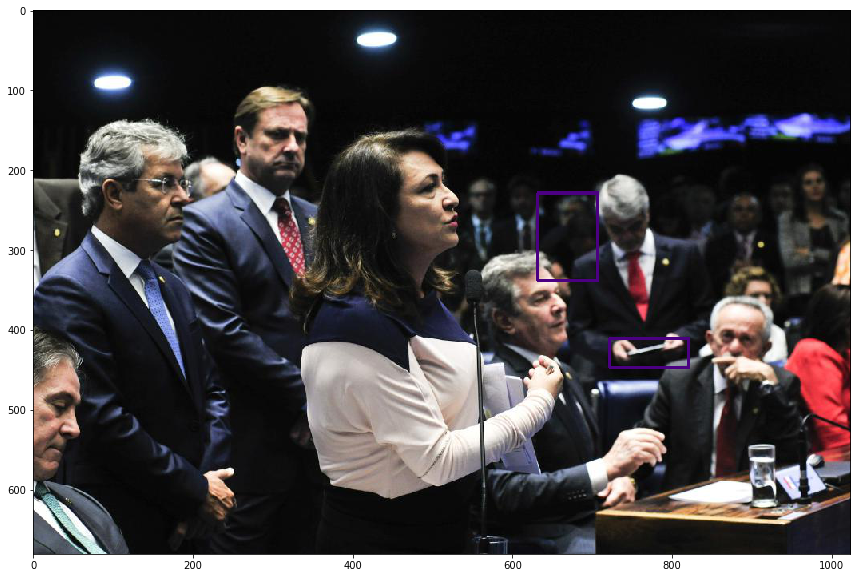

In [304]:
show_tuple_relation(df_test, 200, test_mode=True)

In [116]:
df_trip = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-relationship-triplets.csv'))
df_trip.head()

,LabelName1,LabelName2,RelationshipLabel
0,/m/01599,/m/04bcr3,on
1,/m/05r655,/m/0h8my_4,holds
2,/m/05r655,/m/03k3r,on
3,/m/04yx4,/m/0l14j_,holds
4,/m/05r655,/m/080hkjn,wears


In [117]:
df_trip.loc[df_trip.RelationshipLabel=='is'].shape

(42, 3)

In [118]:
df_trip.shape

(329, 3)